In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('Hackathon_2025_Dataset.csv', nrows=500000)

print(df.head())
print(len(df.columns))
print(df.columns)

                         ID POSTING_DATE  GPI_AGE GPI_CLS_CODE_PT_OCCUP  \
0  000072M61O4ecSTfLYeA0Ia7   2023-07-31       29                 CALIF   
1  000072M61O4ecSTfLYeA0Ia7   2023-06-30       28                 CALIF   
2  000072M61O4ecSTfLYeA0Ia7   2023-05-31       28                 CALIF   
3  000072M61O4ecSTfLYeA0Ia7   2023-04-30       28                 CALIF   
4  000072M61O4ecSTfLYeA0Ia7   2023-03-31       28                 CALIF   

  GPI_CLS_PT_EDU_DESC GPI_COUNTY_NAME GPI_DOMICILE_TYPE GPI_GENDER_CODE  \
0               Liceu          BRASOV             RURAL               F   
1               Liceu          BRASOV             RURAL               F   
2               Liceu          BRASOV             RURAL               F   
3               Liceu          BRASOV             RURAL               F   
4               Liceu          BRASOV             RURAL               F   

  GPI_MARITAL_SATUS_CODE GPI_REGION_NAME  ...  LOA_TOTAL_REFUND_FLAG  \
0                      C  

In [3]:
# Count outliers in each numerical column using the IQR method
numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    Q1 = df[col].quantile(0.1)
    Q3 = df[col].quantile(0.9)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {outliers.shape[0]} outliers")

GPI_AGE: 0 outliers
CLIENT_TENURE: 0 outliers
CLIENT_TENURE_ACTIVE_ACC: 0 outliers
PTS_CIC_OPENED_ND: 0 outliers
PTS_CLIENT_STATUS_ND: 0 outliers
CEC_ALL_ACTIVE_CNT: 7256 outliers
CEC_ALL_PROD_CNT: 25024 outliers
CLO_ALL_ACTIVE_CNT: 3330 outliers
CLO_ALL_PROD_CNT: 2846 outliers
CRT_ALL_ACTIVE_CNT: 129 outliers
DEP_ALL_ACTIVE_CNT: 17247 outliers
DEP_ALL_PROD_CNT: 24775 outliers
ICC_ALL_ACTIVE_CNT: 61 outliers
ICC_ALL_PROD_CNT: 154 outliers
INS_VIG_ALL_ACTIVE_CNT: 13025 outliers
INV_ALL_ACTIVE_CNT: 7253 outliers
PPI_ALL_ACTIVE_CNT: 776 outliers
REFIN_ALL_ACTIVE_CNT: 564 outliers
REFIN_ALL_PROD_CNT: 4573 outliers
TER_ALL_ACTIVE_CNT: 8333 outliers
TER_ALL_PROD_CNT: 37987 outliers
OT_COLT_ALL_PROD_CNT: 17120 outliers
OT_COLT_ALL_ACTIVE_CNT: 16865 outliers
LOA_ALL_PROD_CNT: 2873 outliers
LOA_ALL_ACTIVE_CNT: 3329 outliers
CRT_ALL_PROD_CNT: 451 outliers
CEC_AVG_BALANCE_AMT: 7798 outliers
CEC_TOTAL_BALANCE_AMT: 7175 outliers
CLO_AVG_BALANCE_AMT: 66 outliers
CLO_MAX_BALANCE_AMT: 52 outliers
CLO_

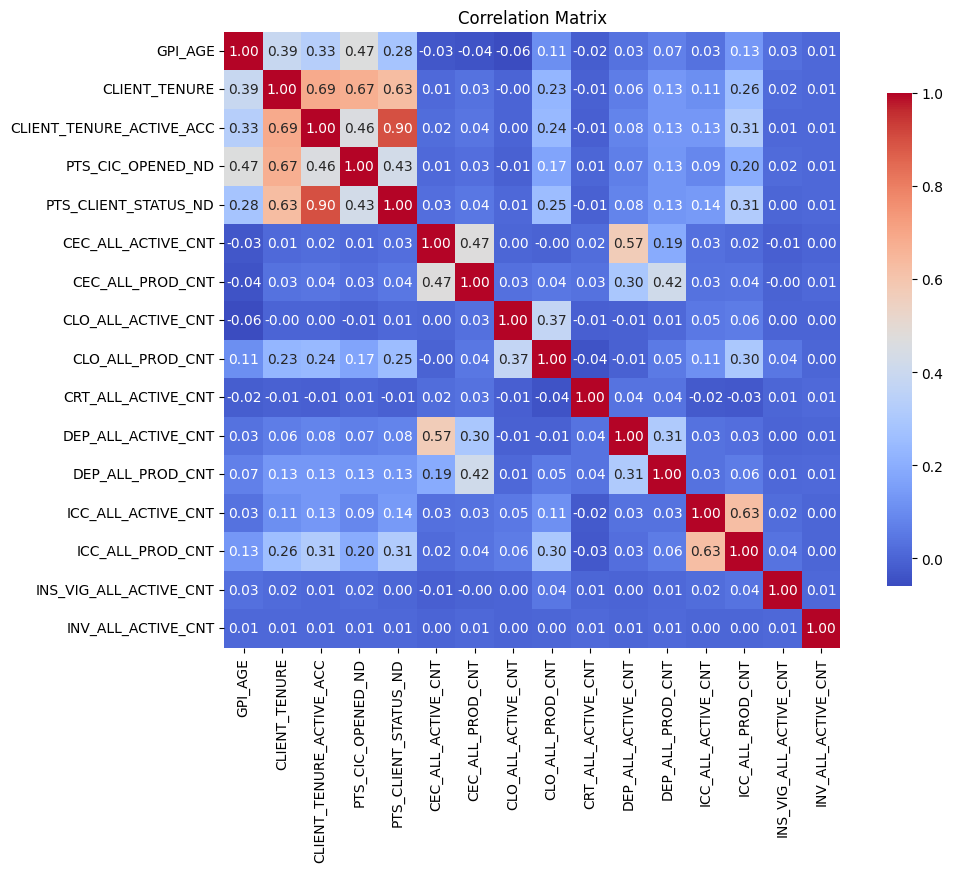

In [4]:
number_df = df.select_dtypes(include=[np.number])

first_16 = number_df.iloc[:, :16]

# correlation matrix
corr = first_16.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

In [5]:
# Get all continuous columns
number_df = df.select_dtypes(include=[np.number])
number_cols = number_df.columns.tolist()
correlation_threshold = 0.9


# Compute correlation matrix
corr_matrix = number_df.corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find columns with correlation above the threshold
to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
print(len(to_drop))
print(f"Dropping columns: {to_drop}")
number_df = number_df.drop(columns=to_drop, errors='ignore')
df = df.drop(columns=to_drop, errors='ignore')

# print(f"Processing columns: {batch_df.columns.tolist()}")
# display(batch_df.head())

print(len(number_df.columns))

27
Dropping columns: ['TER_ALL_PROD_CNT', 'LOA_ALL_PROD_CNT', 'LOA_ALL_ACTIVE_CNT', 'CLO_MAX_BALANCE_AMT', 'CLO_MIN_BALANCE_AMT', 'CLO_TOTAL_BALANCE_AMT', 'CRT_MIN_BALANCE_AMT', 'CRT_TOTAL_BALANCE_AMT', 'DEP_MAX_BALANCE_AMT', 'DEP_MIN_BALANCE_AMT', 'DEP_TOTAL_BALANCE_AMT', 'DTER_TOTAL_BALANCE_AMT', 'ICC_MIN_BALANCE_AMT', 'ICC_TOTAL_BALANCE_AMT', 'OVD_MAX_BALANCE_AMT', 'OVD_MIN_BALANCE_AMT', 'OVD_TOTAL_BALANCE_AMT', 'LOA_TOTAL_BALANCE_AMT', 'LOA_MIN_BALANCE_AMT', 'LOA_MAX_BALANCE_AMT', 'LOA_AVG_BALANCE_AMT', 'ICC_AVG_BALANCE_AMT', 'CRT_FST_ACC_ACTIVE_OPEN_ND', 'OVD_REMAINING_LIMIT_AMT_MIN', 'TRX_OUT_CASH_CNT', 'CHNL_BRANCH_SCANS_DAYS_CNT', 'CHNL_INBOUND_CALLS_DAYS_CNT']
137


In [6]:
# Select numerical columns
number_df = df.select_dtypes(include=[np.number])

# Select categorical columns
cat_df = df.select_dtypes(include=['object', 'category'])

# data not useful for categorical analysis
columns_to_drop = ['ID', 'POSTING_DATE', 'GPI_COUNTY_NAME']
cat_df = cat_df.drop(columns=columns_to_drop, errors='ignore')
# One-hot encode categorical columns
cat_encoded = pd.get_dummies(cat_df, drop_first=True)

# Combine numerical and encoded categorical columns
combined_df = pd.concat([number_df, cat_encoded], axis=1).dropna()

# Standardize the combined data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_df)

# Fit KMeans
kmeans = KMeans(n_clusters=4, random_state=42)

clusters = kmeans.fit_predict(scaled_data)

# Add cluster labels to your DataFrame
df['cluster'] = -1
df.loc[combined_df.index, 'cluster'] = clusters

print(df['cluster'].value_counts())

cluster
2    290089
1    146224
3     53749
0      9938
Name: count, dtype: int64


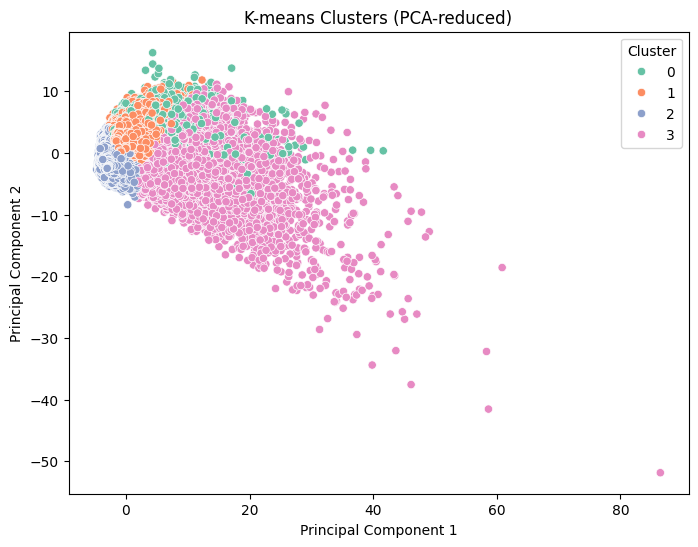


Top 5 features for Principal Component 1:
TRX_OUT_ALL_CNT: 0.253
TRX_OUT_POS_CNT: 0.216
CHNL_IB_LOGINS_CNT: 0.194
MCC_FOOD_CNT: 0.185
TRX_OUT_POS_AMT: 0.182

Top 5 features for Principal Component 2:
CLIENT_TENURE: 0.286
CLIENT_TENURE_ACTIVE_ACC: 0.282
PTS_CLIENT_STATUS_ND: 0.274
PTS_CIC_OPENED_ND: 0.254
ICC_ALL_PROD_CNT: 0.247


In [7]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=reduced_data[:, 0], y=reduced_data[:, 1],
    hue=clusters, palette='Set2', legend='full'
)
plt.title('K-means Clusters (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Get feature names after one-hot encoding
feature_names = combined_df.columns

# Get PCA components (loadings)
loadings = pca.components_

# Show top contributing features for each principal component
n_top = 5  # number of top features to display per component
for i, component in enumerate(loadings):
    indices = np.argsort(np.abs(component))[::-1][:n_top]
    print(f"\nTop {n_top} features for Principal Component {i+1}:")
    for idx in indices:
        print(f"{feature_names[idx]}: {component[idx]:.3f}")

In [8]:
# Calculate mean of each feature for each cluster
cluster_means = combined_df.copy()
cluster_means['cluster'] = clusters
means_by_cluster = cluster_means.groupby('cluster').mean()

# Show the difference between cluster means for each feature
diff = means_by_cluster.max() - means_by_cluster.min()
top_features = diff.abs().sort_values(ascending=False)

print("Top features contributing to cluster separation:")
print(top_features.head(10))

Top features contributing to cluster separation:
DEP_AVG_BALANCE_AMT      34519.777665
DTER_AVG_BALANCE_AMT     24060.777852
CLO_APPROVED_LIMIT       18675.588429
CLO_AVG_BALANCE_AMT      16756.624613
CRT_MAX_BALANCE_AMT      15114.643932
TRX_OUT_ALL_AMT          13740.827905
TRX_IN_ALL_AMT            9900.414255
TRX_IN_CRT_AMT            9844.275761
CEC_AVG_BALANCE_AMT       9695.964070
CEC_TOTAL_BALANCE_AMT     9110.262327
dtype: float64


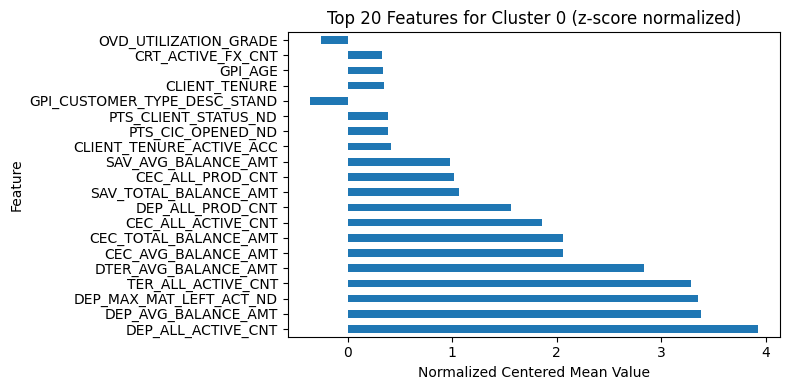

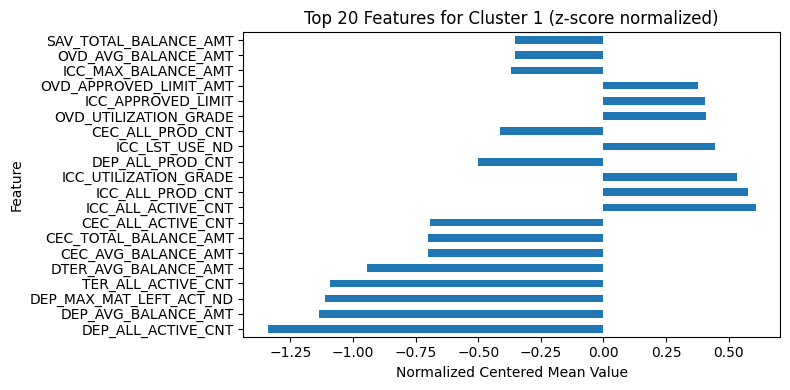

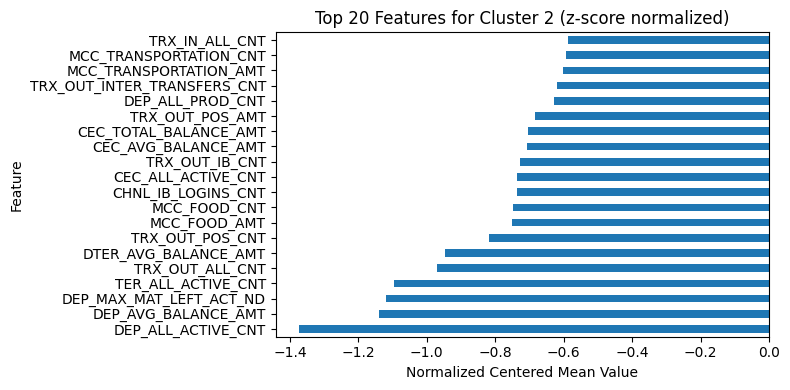

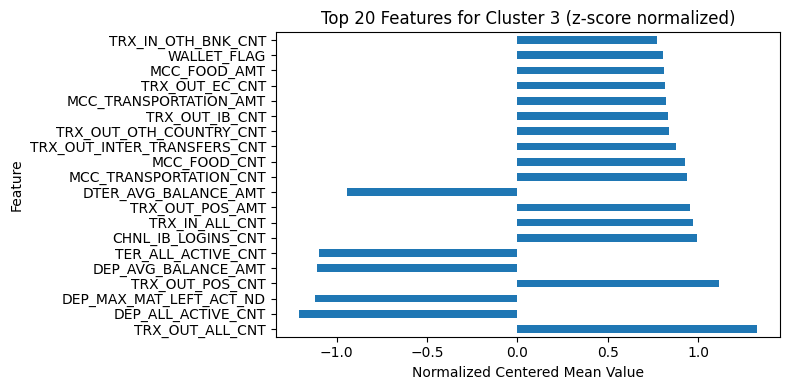

In [14]:
# Calculate mean of each feature for each cluster
cluster_means = combined_df.copy()
cluster_means['cluster'] = clusters
means_by_cluster = cluster_means.groupby('cluster').mean()

# Center and normalize (z-score) the means
means_centered = means_by_cluster - means_by_cluster.mean(axis=0)
feature_stds = combined_df.std(axis=0)
means_normalized = means_centered / feature_stds

# For each cluster, get the top 5 features with the largest absolute deviation
top_n = 20
for cluster in means_normalized.index:
    abs_deviation = means_normalized.loc[cluster].abs()
    top_features = abs_deviation.sort_values(ascending=False).head(top_n)
    values = means_normalized.loc[cluster, top_features.index]
    
    plt.figure(figsize=(8, 4))
    values.plot(kind='barh')
    plt.title(f"Top {top_n} Features for Cluster {cluster} (z-score normalized)")
    plt.xlabel("Normalized Centered Mean Value")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# Notes

Cluster 0: persoane econome
- face multe depozite la termen
- interesat de conturi de economii
- isi analizeaza cheltuielile lunar

Cluster 1: big spenders
- neinteresat de economii
- foloseste cardul de credit
- overdraft des
- posibil interesat de imprumuturi

Cluster 2: underutilizer
- face transferuri rar
- nu face depozite
- posibil sa faca plati cash des
- posibil sa nu cunoasca beneficiile George

Cluster 3: tineri
- multe transferuri intre prieteni
- cheltuieli mai mari pentru transport si mancare
- cash flow in general mai mic
- foloseste rar optiunile de economii